# Import libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# standard libraries
import pandas as pd
import numpy as np

# for model
import tensorflow as tf
!pip install transformers -q
import transformers
from transformers import TFRobertaModel, RobertaTokenizer
from sklearn.metrics import classification_report

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for evaluation metrics
!pip install evaluate -q
from evaluate import load

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 77.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00


# Get the test data

In [2]:
test = pd.read_csv('/content/drive/MyDrive/cola_raw_unbalanced_test.csv')

test

,acceptability,sentence,domain
0,1,The sailors rode the breeze clear of the rocks.,in
1,1,The weights made the rope stretch over the pul...,in
2,1,The mechanical doll wriggled itself loose.,in
3,1,"If you had eaten more, you would want less.",in
4,0,"As you eat the most, you want the least.",in
...,...,...,...
1038,1,John considers Bill silly.,out
1039,1,John considers Bill to be silly.,out
1040,0,John bought a dog for himself to play with.,out
1041,1,John arranged for himself to get the prize.,out


## Take a look at the test data distribution

In [3]:
test['acceptability'].value_counts()

1    719
0    324
Name: acceptability, dtype: int64

In [4]:
len(test[test['acceptability'] == 1]) / len(test)

0.6893576222435283

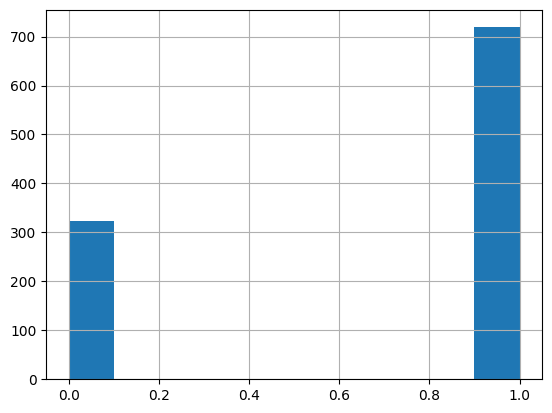

In [5]:
test['acceptability'].hist()
plt.show()

# Run inference on the test set

## Prepare for the model

In [6]:
# Load the tokenizer and model
checkpoint = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(checkpoint)
roberta = TFRobertaModel.from_pretrained(checkpoint)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [7]:
# Set global variables
MAX_LEN = 512

## Tokenize the inputs

In [8]:
x_test = tokenizer(test['sentence'].tolist(),
                    add_special_tokens=True,
                    max_length=MAX_LEN,
                    padding='max_length',
                    return_token_type_ids=True,
                    truncation=True,
                    return_tensors="tf"
                    )

y_test = np.array(test['acceptability'].tolist())

## Define the model

In [9]:
def create_model(llm,
                 num_unfreeze=0,
                 hidden_size=[1024]):

  if num_unfreeze == 0:
    llm.trainable = False
  elif num_unfreeze == 12:
    llm.trainable = True
  else:
    retrain_layers = []

    for retrain_layer_number in range(num_unfreeze):
      layer_code = '_' + str(11 - retrain_layer_number)
      retrain_layers.append(layer_code)

    print('retrain layers: ', retrain_layers)

    for w in llm.weights:
      if not any([x in w.name for x in retrain_layers]):
        w._trainable = False

  input_ids = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int64, name='input_ids_layer')
  token_type_ids = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int64, name='token_type_ids_layer')
  attention_mask = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int64, name='attention_mask_layer')

  llm_inputs = {'input_ids': input_ids,
                'token_type_ids': token_type_ids,
                'attention_mask': attention_mask}

  llm_out = llm(llm_inputs)
  output_token = llm_out.last_hidden_state
  hidden = tf.math.reduce_mean(output_token, axis=1)

  for i, each in enumerate(hidden_size):
    hidden = tf.keras.layers.Dense(each, activation='relu', name=f'hidden_layer_{i}')(hidden)
    hidden = tf.keras.layers.Dropout(0.1)(hidden)

  classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)

  classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

  # Optimizer
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5,
                                      beta_1=0.9,
                                      beta_2=0.98,
                                      epsilon=1e-06,
                                      clipnorm=0.0)

  # Learning rate scheduler
  lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=1e-5,
                                                              decay_steps=5336,
                                                              end_learning_rate=1e-10,
                                                              power=1.0)

  optimizer.lr = lr_schedule

  classification_model.compile(optimizer=optimizer,
                                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                metrics='accuracy')

  return classification_model

## Reloading the trained checkpoint with highest accuracy to evaluate the validation set

In [10]:
roberta = TFRobertaModel.from_pretrained(checkpoint)
model = create_model(roberta, num_unfreeze=12)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [11]:
checkpoint_dir = '/content/drive/MyDrive/GAC_weights/'

In [12]:
inference_filepath = checkpoint_dir + 'modelf.weights.03-0.84.hdf5'
model.load_weights(inference_filepath)

In [13]:
model.evaluate([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test)

33/33 [==============================] - 57s 1s/step - loss: 0.5244 - accuracy: 0.8428


[0.5244082808494568, 0.8427612781524658]

In [14]:
ypred_test = model.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask])

yhat_test = np.where(ypred_test > 0.75, 1, 0)

33/33 [==============================] - 45s 1s/step


In [15]:
matthews_metric = load("matthews_correlation")
mcc = matthews_metric.compute(references=y_test, predictions=yhat_test)
print('MCC: ', mcc)

MCC:  {'matthews_correlation': 0.6139286514201967}


In [16]:
print(classification_report(y_test, yhat_test))

              precision    recall  f1-score   support

           0       0.81      0.64      0.71       324
           1       0.85      0.93      0.89       719

    accuracy                           0.84      1043
   macro avg       0.83      0.79      0.80      1043
weighted avg       0.84      0.84      0.84      1043



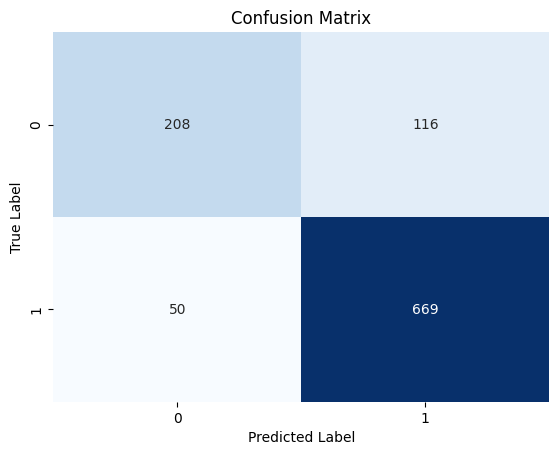

In [17]:
cm = tf.math.confusion_matrix(y_test, yhat_test)

ax = sns.heatmap(cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Confusion Matrix')
plt.show()

## Investigate some samples of misclassification

In [18]:
# FN: True label is acceptable but predicted to be unacceptable
FN_idx = np.where((yhat_test.flatten() == 0) & (y_test == 1))[0]
FN_X = test['sentence'][FN_idx]
print(FN_X.tolist()[:10])
# Based on examples printed out, these are difficult sentences that could be considered unacceptable

['The tank leaked the fluid free.', 'Clearly, John probably will immediately learn French perfectly.', "Mary claimed that eating cabbage, Holly shouldn't.", "I know which book Mag read, and which book Bob said that you hadn't.", 'Rusty talked about himself only after Mary did talk about him.', 'He attributed to a short circuit which was caused by an overloaded transducer the fire which destroyed most of my factory.', 'I talked to Winston about himself.', 'We investigated the area for bombs.', 'Carla slid the book.', 'did the policeman meet in the park?']


In [19]:
# FP: True label is unacceptable but predicted to be acceptable
FP_idx = np.where((yhat_test.flatten() == 1) & (y_test == 0))[0]
FP_X = test['sentence'][FP_idx]
print(FP_X.tolist()[:10])
# Based on examples printed out, these are difficult sentences that could be considered acceptable

['As you eat the most, you want the least.', 'The more you would want, the less you would eat.', 'The more does Bill smoke, the more Susan hates him.', 'Mickey looked up it.', 'The box contained the ball from the tree.', 'The tube was escaped by gas.', 'What the water did to the bottle was fill it.', 'What the water did to the whole bottle was fill it.', 'Mary beautifully plays the violin.', 'Sue gave to Bill a book.']


In [20]:
import copy
test_check = copy.copy(test)

In [21]:
# other two types of error, just to be completionist
TP_idx = np.where((yhat_test.flatten() == 1) & (y_test == 1))[0]
TN_idx = np.where((yhat_test.flatten() == 0) & (y_test == 0))[0]

test_check["error_type"] = 'none'
test_check.loc[FN_idx, "error_type"] = 'FN'
test_check.loc[FP_idx, "error_type"] = 'FP'
test_check.loc[TP_idx, "error_type"] = 'TP'
test_check.loc[TN_idx, "error_type"] = 'TN'

test_check.drop(['acceptability','domain'], axis=1, inplace = True)

#but subset only fp and fn
test_check = test_check.loc[test_check['error_type'].isin(['FN','FP'])]

test_check

,sentence,error_type
4,"As you eat the most, you want the least.",FP
5,"The more you would want, the less you would eat.",FP
13,"The more does Bill smoke, the more Susan hates...",FP
23,Mickey looked up it.,FP
28,The box contained the ball from the tree.,FP
...,...,...
1019,The problem we are discussing is George.,FN
1022,It was believed to be illegal by them to do that.,FP
1028,I gave Pete the book to impress.,FP
1031,I presented Bill with it to read.,FP


# Check common misclassified grammatical error type

In [22]:
# load data
major = pd.read_csv('/content/drive/MyDrive/cola_major_annotations.csv')
minor = pd.read_csv('/content/drive/MyDrive/cola_minor_annotations.csv')
major.head()


,source,domain,acceptability,simple,predicate,adjunct,argument_type,arg_altern,imperative,binding,question,comp_clause,auxiliary,to-vp,"n,_adj",s-syntax,determiner,violations,sentence
0,gj04,In,1,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,The sailors rode the breeze clear of the rocks.
1,gj04,In,1,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,The weights made the rope stretch over the pul...
2,gj04,In,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,The mechanical doll wriggled itself loose.
3,cj99,In,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,"If you had eaten more, you would want less."
4,cj99,In,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,"As you eat the most, you want the least."


In [23]:
# reshape major to have a single column for error type
major = pd.melt(major, id_vars=['sentence'], value_vars=['simple', 'predicate',
       'adjunct', 'argument_type', 'arg_altern', 'imperative', 'binding',
       'question', 'comp_clause', 'auxiliary', 'to-vp', 'n,_adj',
       's-syntax', 'determiner', 'violations'])

major = major[major['value'] == 1]
major.drop(['value'], axis=1, inplace = True)
major.rename(columns = {'variable':'grammatical_error_type'}, inplace = True)

major

,sentence,grammatical_error_type
36,John owns the book.,simple
43,John went home.,simple
45,Us love they.,simple
64,John often meets Mary.,simple
67,We elected me.,simple
...,...,...
15594,John decided Bill to get the prize.,violations
15612,John believes it that Bill is here.,violations
15618,That John is reluctant seems.,violations
15619,It is the problem that he is here.,violations


In [24]:
# left join, all left true
#minor_errors = test_check.merge(minor, how='left', on='sentence')

major_errors = test_check.merge(major, how='left', on='sentence')
major_errors

,sentence,error_type,grammatical_error_type
0,"As you eat the most, you want the least.",FP,s-syntax
1,"As you eat the most, you want the least.",FP,determiner
2,"The more you would want, the less you would eat.",FP,auxiliary
3,"The more you would want, the less you would eat.",FP,s-syntax
4,"The more you would want, the less you would eat.",FP,determiner
...,...,...,...
662,John bought a dog for himself to play with.,FP,binding
663,John bought a dog for himself to play with.,FP,comp_clause
664,John bought a dog for himself to play with.,FP,to-vp
665,John bought a dog for himself to play with.,FP,"n,_adj"


## Count by error type

- The most common type of grammatical error for false positives is **syntax**, followed by **argument type**, **question** and **auxiliary**


- The most common type of grammatical error for false negatives is **auxiliary**, followed by  **arg_altern**,  **s-syntax**

In [25]:
# Groupby and count
counts = major_errors.groupby(['error_type', 'grammatical_error_type']).size().reset_index(name='count')

# Create new column for sorting order
counts['sort_order'] = counts['error_type'].map({'FP': 0, 'FN': 1})

# Sort by sort order, then by count descending
counts = counts.sort_values(['sort_order', 'count'], ascending=[True, False])

# Drop sort order column
counts = counts.drop('sort_order', axis=1)

counts

,error_type,grammatical_error_type,count
25,FP,s-syntax,63
16,FP,argument_type,51
17,FP,auxiliary,51
24,FP,question,48
23,FP,predicate,41
22,FP,"n,_adj",39
15,FP,arg_altern,38
28,FP,violations,32
14,FP,adjunct,31
19,FP,comp_clause,31


## Examples per grammatical error type

Sentences that are grammatically unacceptable but predicted to be acceptable

In [26]:
fp_most_common = ('s-syntax','question','auxiliary','argument_type')

common_fp  = major_errors[(major_errors['error_type'] == 'FP') & major_errors['grammatical_error_type'].isin(fp_most_common)]
common_fp.head()

,sentence,error_type,grammatical_error_type
0,"As you eat the most, you want the least.",FP,s-syntax
2,"The more you would want, the less you would eat.",FP,auxiliary
3,"The more you would want, the less you would eat.",FP,s-syntax
6,"The more does Bill smoke, the more Susan hates...",FP,auxiliary
7,"The more does Bill smoke, the more Susan hates...",FP,s-syntax


Sentences that are grammatically acceptable but predicted to be unacceptable.





In [27]:
fn_most_common = ('auxiliary','arg_altern','s-syntax','argument_type')

common_fn  = major_errors[(major_errors['error_type'] == 'FN') & major_errors['grammatical_error_type'].isin(fn_most_common)]
common_fn.head()

,sentence,error_type,grammatical_error_type
30,The tank leaked the fluid free.,FN,arg_altern
34,"Clearly, John probably will immediately learn ...",FN,auxiliary
35,"Clearly, John probably will immediately learn ...",FN,s-syntax
42,"Mary claimed that eating cabbage, Holly should...",FN,auxiliary
43,"Mary claimed that eating cabbage, Holly should...",FN,s-syntax


## Count by sentence

- Some sentences have more than one error type, so let's see which are the most popular sentences in FP/FN

**- These are the top 5 sentences in FP:**

1. I know that Meg's attracted to Harry, but they don't know who.
2. It has been determined that somebody will be appointed; it's just not clear yet who.
3. The TA's have been arguing about whether some student or other should pass, but I can't now remember which one.
4. As a teacher, you have to deal simultaneously with the administration's pressure on you to succeed, and the children's to be a nice guy.
5. Each of the performers came in, but were sitting so far back that we couldn't see who.



**- These are the top 5 sentences in FN:**

1. Harry told Sue that Albania is a lovely place for a vacation, and Tom.
2.	He shouted again, but I don't know who to.
3.	John thinks it would upset himself to die.
4.	Any tiger has orange fur, marked with black stripes.
5.	On whom are you counting to incriminate himself?


In [28]:
# Groupby and count
sentence_counts = major_errors.groupby(['sentence','error_type']).size().reset_index(name='count')

# Create new column for sorting order
sentence_counts['sort_order'] = sentence_counts['error_type'].map({'FP': 0, 'FN': 1})

# Sort by sort order, then by count descending
sentence_counts = sentence_counts.sort_values(['sort_order', 'count'], ascending=[True, False])

# Drop sort order column
sentence_counts = sentence_counts.drop('sort_order', axis=1)

sentence_counts

,sentence,error_type,count
34,"I know that Meg's attracted to Harry, but they...",FP,12
49,It has been determined that somebody will be a...,FP,9
118,The TA's have been arguing about whether some ...,FP,9
5,"As a teacher, you have to deal simultaneously ...",FP,8
19,"Each of the performers came in, but were sitti...",FP,8
...,...,...,...
37,I might be not going to the party but washing ...,FN,1
40,I saw even the student.,FN,1
134,The storm arrived after the picnic.,FN,1
164,did the policeman meet in the park?,FN,1
